In [38]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
from collections import defaultdict

from Components.ConditionalNormalDistribution import ConditionalNormalDistribution
from Components.DifferentiablePolynomial import DifferentiablePolynomial
from Models.ModelExponential import ModelExponential
from Models.ModelSinCos import ModelSinCos
from Models.ModelLogistic import ModelLogistic
from Models.ModelSigmoid import ModelSigmoid
from Composition.SequentialSystem import SequentialSystem
from SearchAlgorithm.skeleton import BO_skeleton, BO_graph, BO_graph_local_loss, BO_graph_turbo

from GraphDecomposition.DirectedFunctionalGraph import DirectedFunctionalGraph
from Components.DifferentiablePolynomial import DifferentiablePolynomial
from Models.ModelSinCos import ModelSinCos
from Models.ModelConstant import ModelConstant
from Models.ModelWeightedSum import ModelWeightedSum
from Models.ModelExponential import ModelExponential

%load_ext autoreload
%autoreload 2
from GraphDecomposition.Heuristic import *
from helper import *
from Plotting.HeatMapLossFunction import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
from Models.ModelMNIST import ModelMNIST
from mnist.MNISTLoader import *
from helper import *

ground_truth_param_mnist = {"Blackbox7": np.array([0.8,0.8]), 6 : np.array([0.7, 0.9]), 2: np.array([0.5, 0.7]), 12: np.array([0.5, 0.5]), "Blackbox3":np.array([1.2, 0.8]), 4:np.array([-0.3, 0.5]),
                            8 : np.array([0.7, 0.9]), 9 : np.array([-0.7, 0.9]), 10 : np.array([0.7, 0.9]), 11 : np.array([-0.4, 0.8]), 12 : np.array([-0.4, 0.8, 0.1]), 13 : np.array([-0.4, 0.8, 0.1]), 14:np.array([0.5, 0.8])}

ground_truth_param_mnist_original = {"Blackbox7": np.array([0.8,0.8]), 6 : np.array([0.7, 0.9, -0.3]), 2: np.array([0.5, 0.7]), 12: np.array([0.5, 0.5]), "Blackbox3":np.array([1.2, 0.8]), 4:np.array([-0.3, 0.5]),
                            8 : np.array([0.7, 0.9]), 9 : np.array([-0.7, 0.9]), 10 : np.array([0.7, 0.9]), 11 : np.array([-0.4, 0.8]), 12 : np.array([-0.4, 0.8, 0.1]), 13 : np.array([-0.4, 0.8, 0.1]), 14:np.array([0.5, 0.8])}


adding edge from nn_1 to Blackbox3
adding edge from 2 to Blackbox3
adding edge from 4 to Blackbox7
adding edge from 6 to Blackbox7
setting:  [ 0.7  0.9 -0.3]
setting:  [0.5 0.7]
setting:  [-0.3  0.5]
setting:  [1.2 0.8]
setting:  [0.8 0.8]


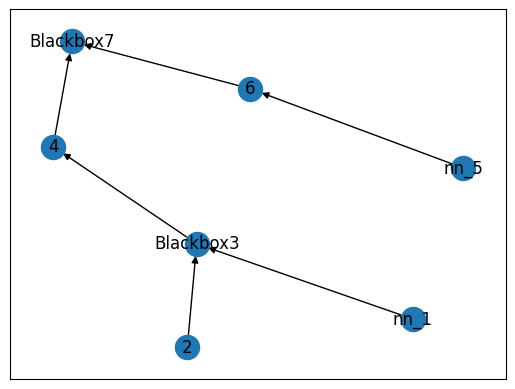

In [40]:

data_generation_seed = 99
bb_component_noise = -0.1
grad_descent_starting_seed = 800

# noises = [-1.0, -0.5, -0.2, 0.2, 0.5, 1.0]
# data_generation_seeds = [99]
# for bb_component_noise in noises:
#     for data_generation_seed in data_generation_seeds:
#         grad_descent_starting_seed = 800
#         dg_nn = create_mnist_system(ground_truth_param_mnist, noise=bb_component_noise, seed=data_generation_seed)
#         #nx.draw_networkx(dg_nn)
#         #grad descent
#         dg_nn.to_perturb = True
#         dg_nn.random_initialize_param(grad_descent_starting_seed)
#         # dg_nn.random_initialize_param(23)
#         lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(dg_nn, itr=500, plot=True)
#         lower_bound_local_loss = [x.detach().cpu().numpy() for x in lower_bound_local_loss]
#         print("minimum system loss: ", min(all_loss["system"]))

data_generation_seed = 99
bb_component_noise = 0.3
grad_descent_starting_seed = 800
dg_nn = create_mnist_system_original(ground_truth_param_mnist_original, noise=bb_component_noise, seed=data_generation_seed)
dg_nn.to_perturb = True
nx.draw_networkx(dg_nn)
plt.show()



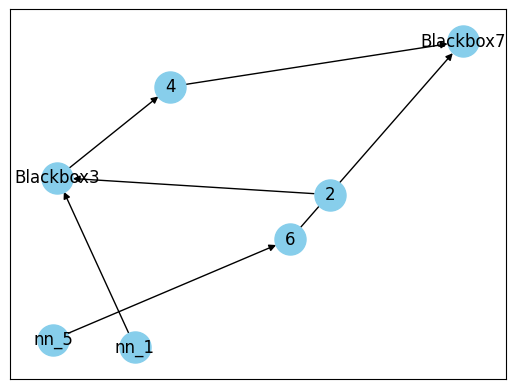

In [20]:
nx.draw_networkx(dg_nn, node_size=500, node_color="skyblue")
plt.show()

In [4]:
dg_nn.system_y

tensor([0.7154, 0.5458, 0.7970, 0.8385, 0.7171, 0.5622, 0.7645, 0.6948, 0.7539,
        0.8397, 0.7216, 0.6316, 0.7416, 0.7317, 0.6605, 0.6177, 0.6882, 0.7879,
        0.7983, 0.7146, 0.5688, 0.5918, 0.6430, 0.7026, 0.7726, 0.6579, 0.5957,
        0.6034, 0.7980, 0.7820, 0.7172, 0.8623, 0.5740, 0.8561, 0.6862, 0.7317,
        0.4605, 0.6193, 0.7288, 0.7164, 0.8315, 0.7006, 0.5198, 0.7540, 0.8438,
        0.7083, 0.6650, 0.5217, 0.6947, 0.8362, 0.5647, 0.8079, 0.7154, 0.6675,
        0.6646, 0.6779, 0.7244, 0.7558, 0.5889, 0.8082, 0.8288, 0.8603, 0.8270,
        0.6901, 0.6887, 0.7421, 0.7978, 0.7393, 0.8122, 0.7215, 0.7202, 0.6180,
        0.7472, 0.8044, 0.7906, 0.6343, 0.7536, 0.6013, 0.6892, 0.9123, 0.6077,
        0.6946, 0.6225, 0.8345, 0.7513, 0.7169, 0.7693, 0.7092, 0.7315, 0.7959,
        0.6061, 0.7287, 0.6897, 0.6268, 0.7822, 0.7691, 0.8255, 0.7276, 0.7509,
        0.6594], dtype=torch.float64)

In [11]:
dg_nn.nodes

NodeView(('nn_1', 'nn_5', 6, 2, 4, 'Blackbox3', 'Blackbox7'))

In [5]:
dg_nn.random_initialize_param(25)
dg_nn.to_perturb = True
print(dg_nn.get_system_loss())
dg_nn.fit_locally_partial(25)
print(dg_nn.get_system_loss())

tensor(0.7120, dtype=torch.float64)
tensor(0.3464, dtype=torch.float64)


final system loss:  tensor(0.2151, dtype=torch.float64)


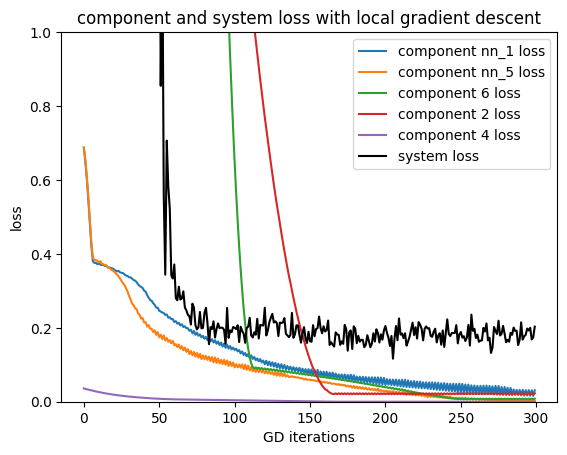

minimum system loss:  tensor(0.1165, dtype=torch.float64)


In [41]:
#grad descent
dg_nn.to_perturb = True
dg_nn.random_initialize_param(5)
dg_nn.noise_std = 0.2
# dg_nn.random_initialize_param(23)
lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(dg_nn, itr=300, plot=True)
lower_bound_local_loss = [x.detach().cpu().numpy() for x in lower_bound_local_loss]
print("minimum system loss: ", min(all_loss["system"]))

# #grad descent
# dg_nn.to_perturb = True
# dg_nn.random_initialize_param(5)
# dg_nn.noise_std = 0.2
# # dg_nn.random_initialize_param(23)
# lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(dg_nn, itr=300, plot=True)
# lower_bound_local_loss = [x.detach().cpu().numpy() for x in lower_bound_local_loss]
# print("minimum system loss: ", min(all_loss["system"]))

# #grad descent
# dg_nn.to_perturb = True
# dg_nn.random_initialize_param(5)
# dg_nn.noise_std = 0.2
# # dg_nn.random_initialize_param(23)
# lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(dg_nn, itr=300, plot=True)
# lower_bound_local_loss = [x.detach().cpu().numpy() for x in lower_bound_local_loss]
# print("minimum system loss: ", min(all_loss["system"]))

# #grad descent
# dg_nn.to_perturb = True
# dg_nn.random_initialize_param(5)
# dg_nn.noise_std = 0.2
# # dg_nn.random_initialize_param(23)
# lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(dg_nn, itr=300, plot=True)
# lower_bound_local_loss = [x.detach().cpu().numpy() for x in lower_bound_local_loss]
# print("minimum system loss: ", min(all_loss["system"]))

# #grad descent
# dg_nn.to_perturb = True
# dg_nn.random_initialize_param(5)
# dg_nn.noise_std = 0.2
# # dg_nn.random_initialize_param(23)
# lower_bound_local_loss, all_loss = show_system_loss_from_grad_descent(dg_nn, itr=300, plot=True)
# lower_bound_local_loss = [x.detach().cpu().numpy() for x in lower_bound_local_loss]
# print("minimum system loss: ", min(all_loss["system"]))

In [22]:
print(lower_bound_local_loss)
dg_nn.nodes

[array(0.00978248, dtype=float32), array(0.00050065, dtype=float32), array(0.00217508), array(0.00539404), array(0.00041745)]


NodeView(('nn_1', 'nn_5', 6, 2, 4, 'Blackbox3', 'Blackbox7'))

In [23]:
dg_nn.random_initialize_param()
dg_nn.to_perturb = True
print(dg_nn.get_system_loss())

AttributeError: 'DirectedFunctionalGraph' object has no attribute 'components'

In [ ]:

# vanilla BO
import botorch
import time
botorch.settings.debug = False
botorch.settings.debug


vanilla_all_trials = []
trials = 100
        
for x in range(trials):
    if len(vanilla_all_trials) >= 5:
        break

    now = time.time()
    dg_nn.random_initialize_param(5)
    print(dg_nn.get_system_loss())
    for x in range(100):
        dg_nn.nodes["nn_1"]["component"].do_one_descent_on_local()
        dg_nn.nodes["nn_5"]["component"].do_one_descent_on_local()
    print(dg_nn.get_system_loss())
    #nx.relabel_nodes(dg_nn, {"nn_1" : "Blackbox_1", "nn_5": "Blackbox_5"}, copy=False)
    #all_best_losses, _, _ = BO_graph(dg_nn,printout=True,iteration=20)
    all_best_losses, _, _ = BO_graph_turbo(dg_nn,printout=True,iteration=100,to_normalize_y=True,lower_bound=-1.8, upper_bound=1.8, batch_size=2)
    
    vanilla_all_trials.append(all_best_losses)
    later = time.time()
    difference = (later - now)
    print("total time taken: ", difference)

vanilla_all_trials = np.array(vanilla_all_trials)
np.savetxt("result/mnist_turbo_small_graph_smaller_bound.csv", vanilla_all_trials)

In [42]:

# vanilla BO
import botorch
import time
botorch.settings.debug = False
botorch.settings.debug


vanilla_all_trials = []
trials = 100
        
for x in range(trials):
    if len(vanilla_all_trials) >= 1:
        break

    now = time.time()
    dg_nn.random_initialize_param(51)
    print(dg_nn.get_system_loss())
    for x in range(100):
        dg_nn.nodes["nn_1"]["component"].do_one_descent_on_local()
        dg_nn.nodes["nn_5"]["component"].do_one_descent_on_local()
    print(dg_nn.get_system_loss())
    #nx.relabel_nodes(dg_nn, {"nn_1" : "Blackbox_1", "nn_5": "Blackbox_5"}, copy=False)
    all_best_losses, _, _ = BO_graph(dg_nn,printout=True,iteration=200)
    
    vanilla_all_trials.append(all_best_losses)
    later = time.time()
    difference = (later - now)
    print("total time taken: ", difference)

vanilla_all_trials = np.array(vanilla_all_trials)
#np.savetxt("result/mnist_vanilla_BO_data_seed_800_starting_grad_seed_99_noise_pos_0.5.csv", vanilla_all_trials)

tensor(21540.3995, dtype=torch.float64)
tensor(135.3918, dtype=torch.float64)
BO iteration:  0
Current best objective:  -10000
current loss:  tensor(-249.6231, dtype=torch.float64)
time taken for one BO iteration:  0.39842700958251953
BO iteration:  1
Current best objective:  tensor(-249.6231, dtype=torch.float64)
current loss:  tensor(-0.9262, dtype=torch.float64)
time taken for one BO iteration:  0.42357659339904785
BO iteration:  2
Current best objective:  tensor(-0.9262, dtype=torch.float64)
current loss:  tensor(-0.9301, dtype=torch.float64)
time taken for one BO iteration:  0.4277031421661377
BO iteration:  3
Current best objective:  tensor(-0.9262, dtype=torch.float64)
current loss:  tensor(-0.8910, dtype=torch.float64)
time taken for one BO iteration:  0.40966296195983887
BO iteration:  4
Current best objective:  tensor(-0.8910, dtype=torch.float64)
current loss:  tensor(-0.9200, dtype=torch.float64)
time taken for one BO iteration:  0.3986544609069824
BO iteration:  5
Current 

In [21]:
bounds = torch.tensor([np.array(lower_bound_local_loss) * 1, np.array(lower_bound_local_loss) * 3])
print(bounds)

tensor([[0.0098, 0.0005, 0.0022, 0.0054, 0.0004],
        [0.0293, 0.0015, 0.0065, 0.0162, 0.0013]], dtype=torch.float64)


number of attempts:  0
trial of our BO (successful):  0
BO iteration:  0
Current best objective:  -10000
target loss: tensor([7.2212e-01, 7.2194e-01, 4.3528e+01, 1.2302e+01, 3.7125e-02],
       dtype=torch.float64)
reached loss: tensor([[7.2212e-01, 7.2194e-01, 4.3528e+01, 1.2302e+01, 3.7125e-02]],
       dtype=torch.float64)
candidate param:  tensor([[2.7493e-01, 1.7438e-02, 6.1481e-02, 1.9967e-01, 5.2598e-05]],
       dtype=torch.float64)
time taken for one BO iteration:  0.414306640625
BO iteration:  1
Current best objective:  tensor(-24.2014, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  55.065202713012695
10


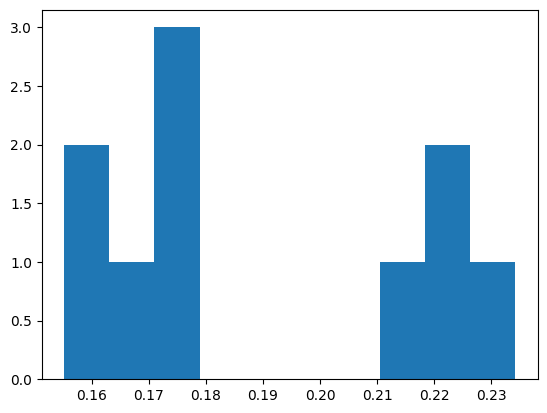

number of system calls:  10
time taken for system evaluation:  3.6559674739837646
best loss:  tensor(0.1552, dtype=torch.float64)
target loss: tensor([2.7493e-01, 1.7438e-02, 6.1481e-02, 1.9967e-01, 5.2598e-05],
       dtype=torch.float64)
reached loss: tensor([[2.6972e-01, 1.4062e-02, 7.5657e-02, 2.0886e-01, 3.4469e-05]],
       dtype=torch.float64)
candidate param:  tensor([[2.6972e-01, 1.4062e-02, 7.5657e-02, 2.0886e-01, 3.4469e-05]],
       dtype=torch.float64)
time taken for one BO iteration:  59.211833000183105
BO iteration:  2
Current best objective:  tensor(-0.1552, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  54.845862865448
10


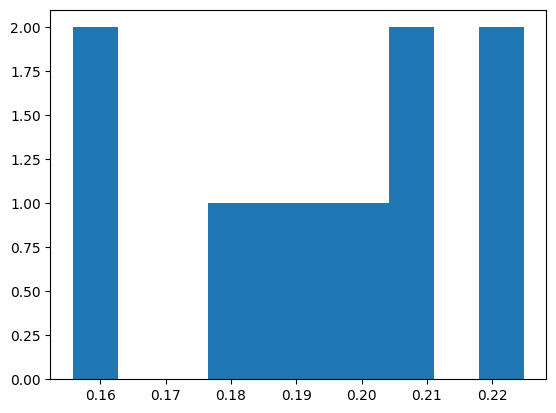

number of system calls:  10
time taken for system evaluation:  2.803769588470459
best loss:  tensor(0.1558, dtype=torch.float64)
target loss: tensor([2.6972e-01, 1.4062e-02, 7.5657e-02, 2.0886e-01, 3.4469e-05],
       dtype=torch.float64)
reached loss: tensor([[2.7076e-01, 1.1368e-02, 7.4701e-02, 2.1674e-01, 4.0748e-05]],
       dtype=torch.float64)
candidate param:  tensor([[2.7022e-01, 1.2763e-02, 7.5196e-02, 2.1266e-01, 3.7499e-05]],
       dtype=torch.float64)
time taken for one BO iteration:  58.30588245391846
BO iteration:  3
Current best objective:  tensor(-0.1552, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  54.42632460594177
10


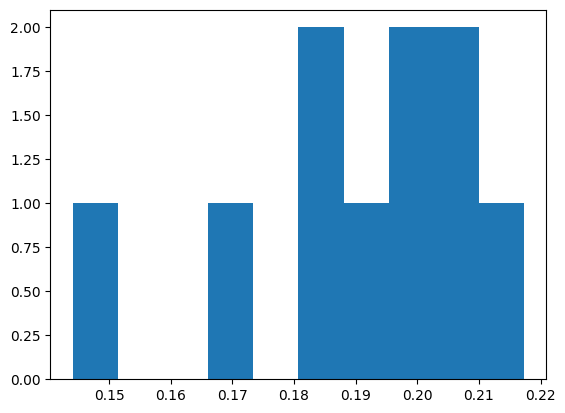

number of system calls:  10
time taken for system evaluation:  3.907827615737915
best loss:  tensor(0.1441, dtype=torch.float64)
target loss: tensor([2.7022e-01, 1.2763e-02, 7.5196e-02, 2.1266e-01, 3.7499e-05],
       dtype=torch.float64)
reached loss: tensor([[3.6712e-01, 7.8581e-03, 7.8973e-02, 2.2559e-01, 2.9083e-05]],
       dtype=torch.float64)
candidate param:  tensor([[3.0905e-01, 2.8308e-03, 8.4447e-02, 2.2621e-01, 3.2005e-05]],
       dtype=torch.float64)
time taken for one BO iteration:  58.72956705093384
BO iteration:  4
Current best objective:  tensor(-0.1441, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  55.17309236526489
10


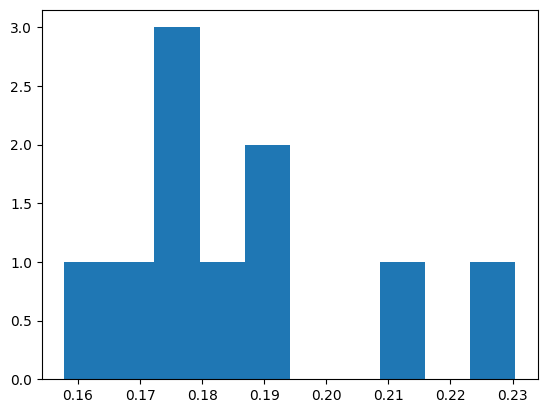

number of system calls:  10
time taken for system evaluation:  4.048106908798218
best loss:  tensor(0.1578, dtype=torch.float64)
target loss: tensor([3.0905e-01, 2.8308e-03, 8.4447e-02, 2.2621e-01, 3.2005e-05],
       dtype=torch.float64)
reached loss: tensor([[3.1351e-01, 1.4037e-03, 9.2545e-02, 2.3595e-01, 5.3726e-05]],
       dtype=torch.float64)
candidate param:  tensor([[3.0905e-01, 2.5735e-02, 5.4164e-02, 2.1278e-01, 3.2005e-05]],
       dtype=torch.float64)
time taken for one BO iteration:  59.73061513900757
BO iteration:  5
Current best objective:  tensor(-0.1441, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  55.33195662498474
10


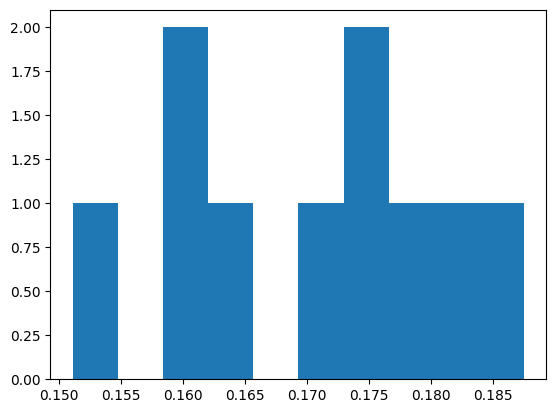

number of system calls:  10
time taken for system evaluation:  4.116306781768799
best loss:  tensor(0.1511, dtype=torch.float64)
target loss: tensor([3.0905e-01, 2.5735e-02, 5.4164e-02, 2.1278e-01, 3.2005e-05],
       dtype=torch.float64)
reached loss: tensor([[3.0394e-01, 2.2734e-02, 5.8600e-02, 2.3336e-01, 5.1818e-05]],
       dtype=torch.float64)
candidate param:  tensor([[3.0905e-01, 2.8308e-03, 6.7274e-02, 1.9119e-01, 3.2005e-05]],
       dtype=torch.float64)
time taken for one BO iteration:  59.88189125061035
BO iteration:  6
Current best objective:  tensor(-0.1441, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  53.88321280479431
10


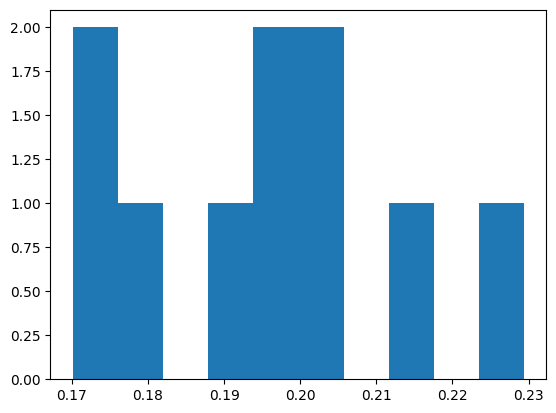

number of system calls:  10
time taken for system evaluation:  3.629589080810547
best loss:  tensor(0.1702, dtype=torch.float64)
target loss: tensor([3.0905e-01, 2.8308e-03, 6.7274e-02, 1.9119e-01, 3.2005e-05],
       dtype=torch.float64)
reached loss: tensor([[3.6694e-01, 1.9565e-03, 7.0860e-02, 2.0379e-01, 5.6310e-05]],
       dtype=torch.float64)
candidate param:  tensor([[3.0905e-01, 2.5735e-02, 8.4447e-02, 1.9023e-01, 3.2005e-05]],
       dtype=torch.float64)
time taken for one BO iteration:  57.92865872383118
BO iteration:  7
Current best objective:  tensor(-0.1441, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


time taken for loss recovery:  52.28724694252014
10


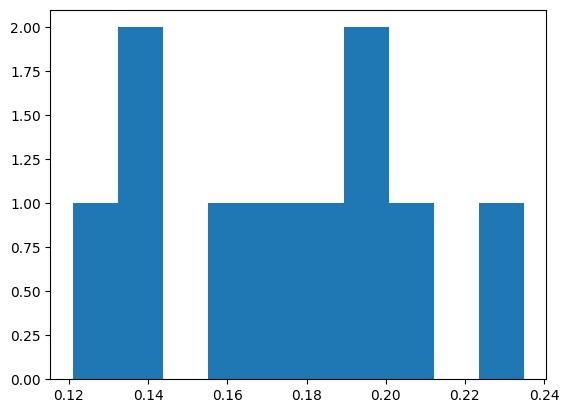

number of system calls:  10
time taken for system evaluation:  3.308591365814209
best loss:  tensor(0.1210, dtype=torch.float64)
target loss: tensor([3.0905e-01, 2.5735e-02, 8.4447e-02, 1.9023e-01, 3.2005e-05],
       dtype=torch.float64)
reached loss: tensor([[3.0054e-01, 3.8642e-01, 9.2715e-02, 2.0738e-01, 3.0664e-05]],
       dtype=torch.float64)
candidate param:  tensor([[3.0905e-01, 2.5735e-02, 8.4447e-02, 1.7274e-01, 2.9096e-04]],
       dtype=torch.float64)
time taken for one BO iteration:  56.01823306083679
BO iteration:  8
Current best objective:  tensor(-0.1210, dtype=torch.float64)


/home/chenzhil/AutoAI/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


In [43]:
our_bo_trial = 1
loss_space_bo_all_trials = []
#lower_bound_local_loss = np.array([[0.04690535], [4.3721084e-05], [0.00128291], [0.00230525], [0.01456002], [4.15571211e-05], [0.00304988], [0.00065909], [0.03127085], [0.11541819], [0.07509221], [0.0516401]]).flatten()l
for x in range(50):
    print("number of attempts: ", x)
    print("trial of our BO (successful): ", len(loss_space_bo_all_trials))
    if len(loss_space_bo_all_trials) >= our_bo_trial:
        break
    
    dg_nn.random_initialize_param(5)      
    bounds = torch.tensor([np.array(lower_bound_local_loss) * 1.1, np.array(lower_bound_local_loss) * 10])
    all_best_losses_ours, best_param = BO_graph_local_loss(dg_nn, bounds, "nn_lookup", samples=10, iteration=20)
    loss_space_bo_all_trials.append(all_best_losses_ours)

    
loss_space_bo_all_trials = np.array(loss_space_bo_all_trials)
np.savetxt("result/mnist_testing.csv", loss_space_bo_all_trials)

In [ ]:
print(x)